<a href="https://colab.research.google.com/github/sandeepkumar8990/Bike-sharing-prediction-LSTM-/blob/main/Bike_sharing_prediction(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bike Demand Prediction with LSTMs using TensorFlow and Keras**

In [11]:
#importing tensorflow library.
import tensorflow as tf
tf.__version__

'2.3.0'

In [12]:
#Installing kaggle module in colab for downloading the dataset. 
!pip install -q kaggle

In [13]:
#making a kaggle directory.
!mkdir -p ~/.kaggle

In [14]:

!cp kaggle.json ~/.kaggle/

In [15]:
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
#downlaoding the dataset from kaggle
!kaggle datasets download -d hmavrodiev/london-bike-sharing-dataset

  0% 0.00/165k [00:00<?, ?B/s]
100% 165k/165k [00:00<00:00, 50.9MB/s]


In [17]:
#moving downloaded datato new folder 'tomatodisease'.
!mkdir bike_sharing
!mv london-bike-sharing-dataset.zip bike_sharing

In [18]:
%cd bike_sharing/

/content/bike_sharing


In [19]:
#downloaded data is in zip format.so,we need to unzip the file.
!unzip london-bike-sharing-dataset.zip

Archive:  london-bike-sharing-dataset.zip
  inflating: london_merged.csv       


In [20]:
#importing the necessary libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
sns.set_style("darkgrid")

In [21]:
#reading the downlaoded data.
df=pd.read_csv('/content/bike_sharing/london_merged.csv',parse_dates=['timestamp'],index_col='timestamp')

In [22]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [23]:
df.tail()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


In [24]:
df.shape

(17414, 9)

Features we have:

* timestamp - timestamp field for grouping the data
* cnt - the count of a new bike shares
* t1 - real temperature in C
* t2 - temperature in C “feels like”
* hum - humidity in percentage
* wind_speed - wind speed in km/h
* weather_code - category of the weather
* is_holiday - boolean field - 1 holiday / 0 non holiday
* is_weekend - boolean field - 1 if the day is weekend
* season - category field meteorological seasons: 0-spring ;            
  1-summer;   2-fall; 3-winter.




In [25]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [26]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


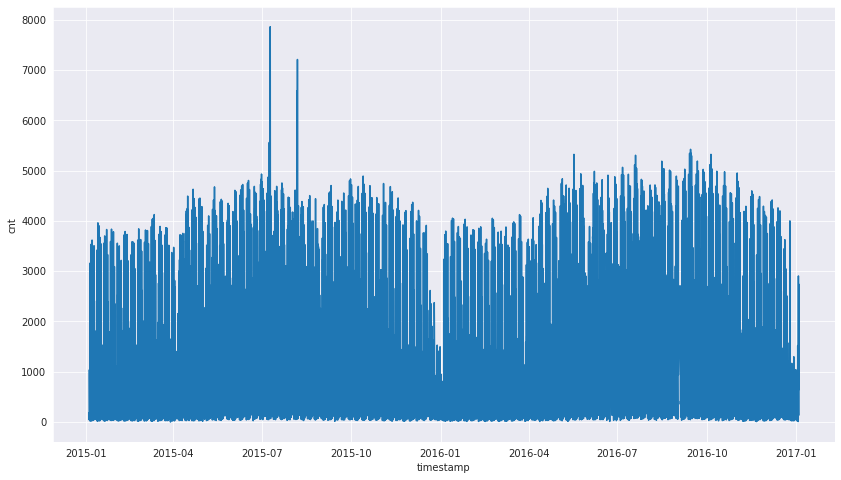

In [28]:
plt.figure(figsize=(14,8))
sns.lineplot(data=df,x=df.index,y=df.cnt)

* Most of Bike sharing counts are between 4k to 5k.
* We can aslo observe bike sharings in the year 2016 jan are very low.

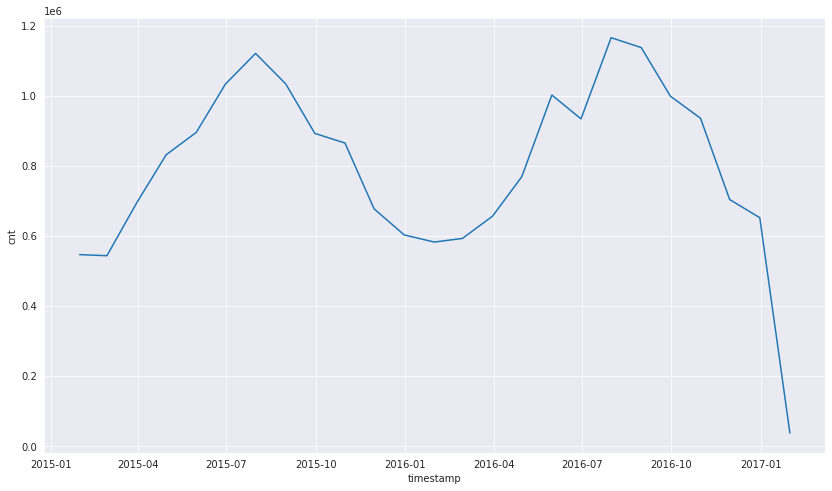

In [29]:
df_month=df.resample("M").sum()
plt.figure(figsize=(14,8))
sns.lineplot(data=df_month,x=df_month.index,y=df_month.cnt)

* Sampled the data based on Month.
* We can Observe bike sharings in the year 2015-8th & 2016-8th months are very high.
* In 2017-Feb Bike sharing are very low.

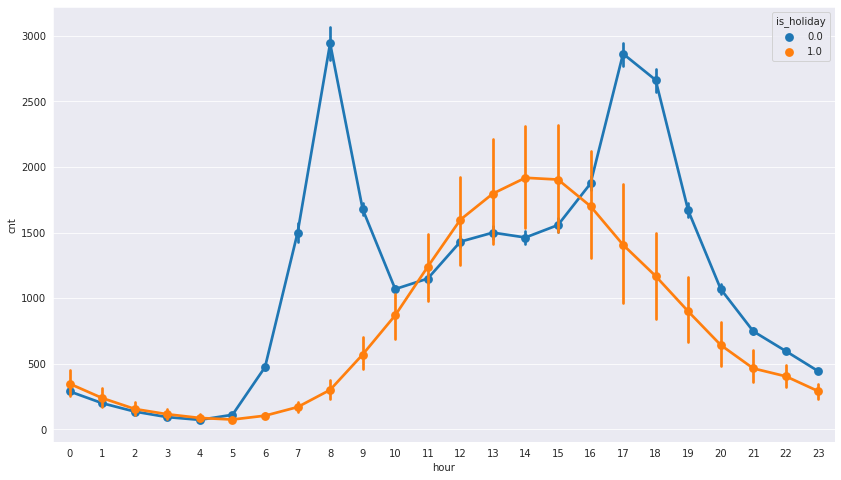

In [30]:
plt.figure(figsize=(14,8))
sns.pointplot(x='hour',y='cnt',hue='is_holiday',data=df)

* During Non holidays Bike sharings are high at morning 8am & also high at 5pm.
* During Holidays  Bike sharings are high at between 2 and 3 hours.

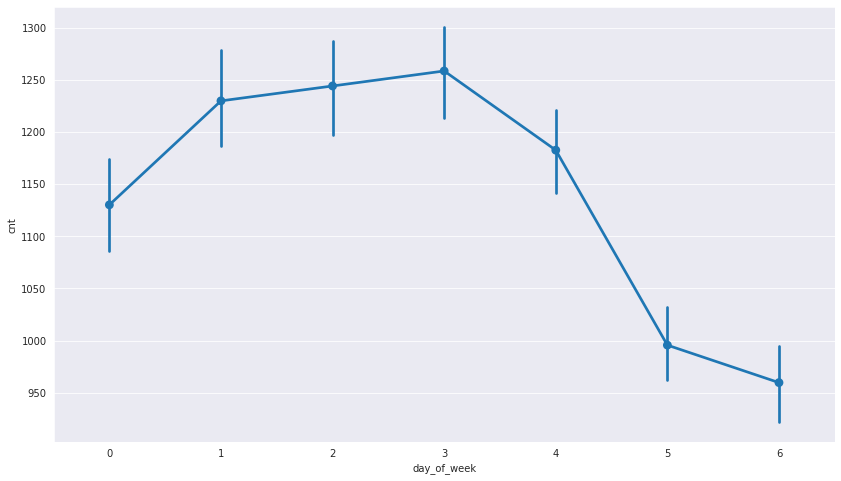

In [31]:
plt.figure(figsize=(14,8))
sns.pointplot(x='day_of_week',y='cnt',data=df)

* In a week Bike sharings are high in first 4 days.

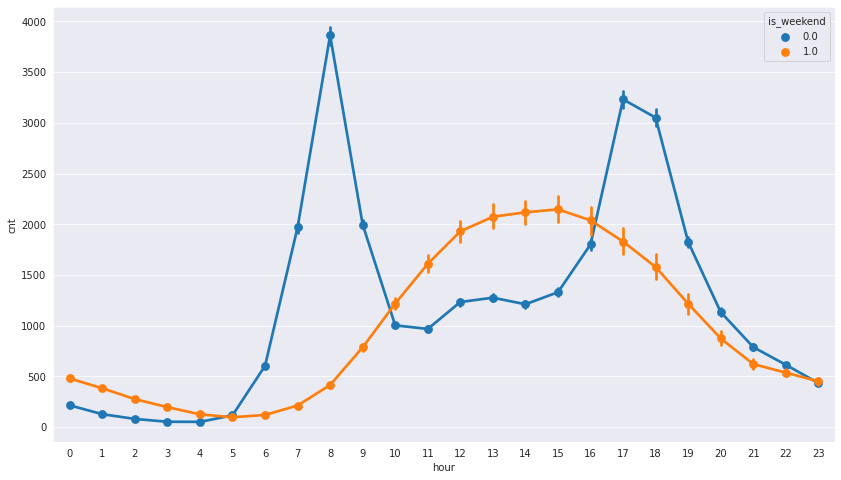

In [32]:
plt.figure(figsize=(14,8))
sns.pointplot(x='hour',y='cnt',hue='is_weekend',data=df)

* During the Non-Weekends bike sharings are high in morning 8 "o" clock and also high in evening 5 to 6 hours.
* Because people go to colleges,schools,universities or offices in the morning and in evening they return from the schools,colleges and officies.
* During the Weekends bike sharings are high at 2 'o' clock

In [33]:
#Splitting the data into train and test.train=90% and test=10%
train_size=int(len(df) * 0.9)
test_size=len(df) - train_size
train,test=df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train),len(test))

15672 1742


In [35]:
print(train.shape)
print(test.shape)

(15672, 13)
(1742, 13)


In [36]:
#Standardizing the below columns with the RobustScalar foe train data and test data. 
cols=['t1','t2','hum','wind_speed']

from sklearn.preprocessing import RobustScaler
transformer=RobustScaler()

transformer=transformer.fit(train[cols].to_numpy())

train.loc[:,cols]=transformer.transform(train[cols].to_numpy())

test.loc[:,cols]=transformer.transform(test[cols].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [37]:
#Standardzing the cnt column.
cnt_transformer=RobustScaler()
cnt_transformer=cnt_transformer.fit(train[['cnt']])

train['cnt']=cnt_transformer.transform(train[['cnt']])

test['cnt']=cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
#Preparing the trainx and trainy with below function.
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [39]:

time_steps=24

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

In [40]:
print(X_train.shape, y_train.shape)

(15648, 24, 13) (15648,)


In [77]:
# define model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,LSTM

model=Sequential()
model.add(LSTM(120, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(60, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [78]:
#Fitting model
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=25, batch_size=16,shuffle=True)

Epoch 1/25
978/978 [==============================] - 26s 26ms/step - loss: 1.5322 - val_loss: 0.1394
Epoch 2/25
978/978 [==============================] - 26s 26ms/step - loss: 0.1470 - val_loss: 0.0804
Epoch 3/25
978/978 [==============================] - 26s 27ms/step - loss: 0.0852 - val_loss: 0.0440
Epoch 4/25
978/978 [==============================] - 26s 26ms/step - loss: 0.0680 - val_loss: 0.0606
Epoch 5/25
978/978 [==============================] - 26s 26ms/step - loss: 0.0592 - val_loss: 0.0287
Epoch 6/25
978/978 [==============================] - 26s 26ms/step - loss: 0.0514 - val_loss: 0.0446
Epoch 7/25
978/978 [==============================] - 26s 26ms/step - loss: 0.0499 - val_loss: 0.0379
Epoch 8/25
978/978 [==============================] - 26s 26ms/step - loss: 0.0458 - val_loss: 0.0455
Epoch 9/25
978/978 [==============================] - 26s 26ms/step - loss: 0.0475 - val_loss: 0.0521
Epoch 10/25
978/978 [==============================] - 26s 26ms/step - loss: 0.042

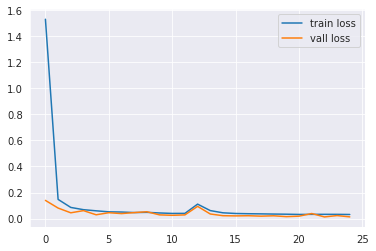

In [79]:
#ploting accuracy and loss graph.
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='vall loss')
plt.legend()
plt.show()


In [85]:
#predicting on test data
y_pred = model.predict(X_test)
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))#Undo scaling
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))

In [86]:
#checking the root mean sqred error
from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
rmse_lstm

163.39486386084565

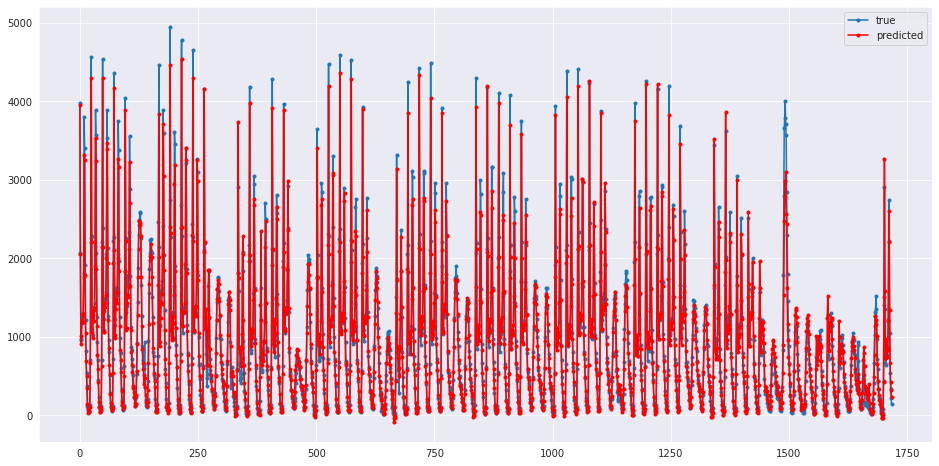

In [94]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(),marker='.', label='true')
plt.plot(y_pred_inv.flatten(),'r',marker='.' ,label='predicted')
plt.legend()

We can Observe both predicted values and actual values are in the same line.